In [1]:
from datasets.datasets import SHHSdataset
from datasets.augmentations import AugmentationModule
from utils.helper_functions import get_data_path
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import scipy.signal as signal
import torchaudio.functional as F

C:\Users\tomsm\anaconda3\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
torch.tensor(1.2).unsqueeze(0)

tensor([1.2000])

In [3]:
batch_size = 3
aug_module=AugmentationModule(
            batch_size=batch_size,
            noise_min=0.3,
            noise_max=0.3,
            zeromask_min=300,
            zeromask_max=500,
            amplitude_min=1.4,
            amplitude_max=1.5,
            timeshift_min=90,
            timeshift_max=100,
            freq_window=2
        )
ds = SHHSdataset(data_path=get_data_path(),
                 first_patient=5,
                 num_patients=1,
                 window_size=4)


Size of patients: 1


C:\Users\tomsm\anaconda3\lib\site-packages\scipy\signal\_filter_design.py:2458: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Wn = asarray(Wn)
C:\Users\tomsm\anaconda3\lib\site-packages\scipy\signal\_filter_design.py:2458: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Wn = asarray(Wn)


In [4]:
dl = data.DataLoader(dataset=ds, batch_size=batch_size, shuffle=False)
batch = list(iter(dl))[0]
batch[0].size()

torch.Size([3, 4, 3000])

In [11]:
x = batch[0].squeeze(1)
print("shape x: ", x.shape)
x_am = aug_module.amplitude_scale(x.clone(), torch.tensor([1.3, 0.5, 1.3]))
x_ts = aug_module.time_shift(x.clone(), (100,-100,100))

#b, a = signal.butter(2, (0.1, 10), btype='bandstop', fs=100, output='ba')
#x_filtered = F.lfilter(x.clone(), torch.as_tensor(a, dtype=torch.float32), torch.as_tensor(b, dtype=torch.float32), clamp=False)
#plt.plot(x[0,10:50])
#plt.plot(x_filtered[0,:])
x_zm = aug_module.zero_mask(x.clone(), torch.tensor([[2700,2800], [2400,2500], [2500, 2600]], dtype=torch.int32))
x_filtered = aug_module.bandpass_filter(x.clone(), 9)
x_gn = aug_module.gaussian_noise(x.clone(), torch.tensor([0.3, 0.5, 0.2]))

shape x:  torch.Size([3, 3000])


In [12]:
x_augs = [x_am, x_ts, x_zm, x_filtered, x_gn]
index = 0
x_augs = [t[index,:] for t in x_augs]
x = x[index,:]

aug_names = ['Amplitude shift',
             'Timeshift',
             'Zero-mask',
             'Bandstop filter',
             'Gaussian noise']

Text(0.5, 0, 'time')

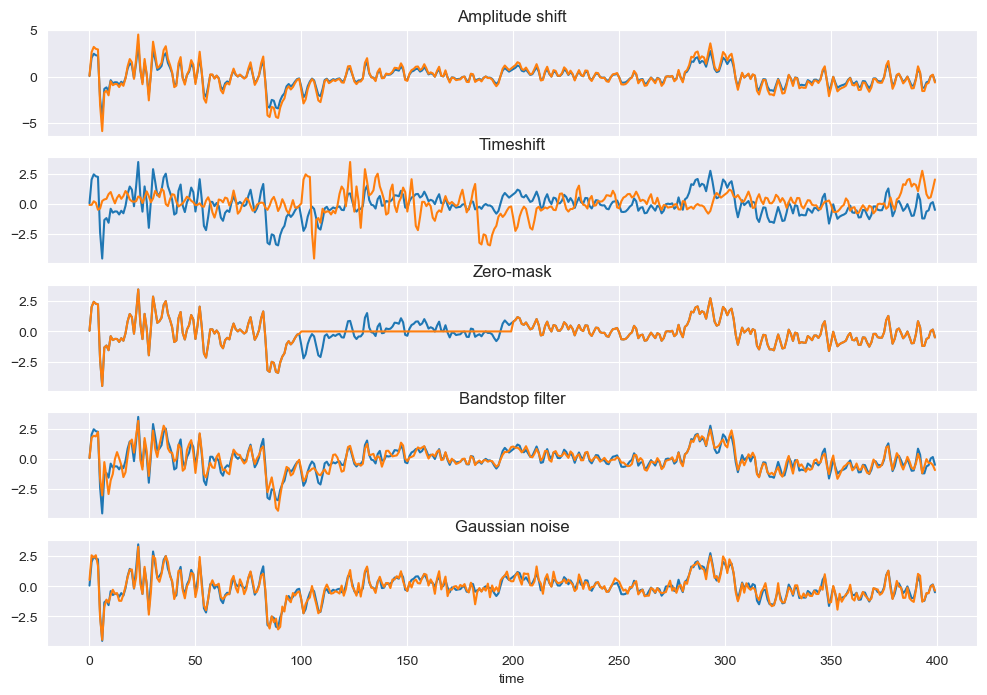

In [13]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
fig, axs = plt.subplots(len(x_augs), figsize=(12,8), sharex='all')
for i in range(len(x_augs)):
    axs[i].plot(x[2600:3000])
    axs[i].plot(x_augs[i][2600:3000])
    axs[i].set_title(aug_names[i])
axs[4].set_xlabel("time")
#plt.savefig('augmentations.png', facecolor="white")